# Miller age

In [1]:
ood_seed = 11

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Lung ciliated cells', '21.0'), 165)


Removed datapoint: 165

train         5826
validation    1414
ood            165
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 105351.28it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1112621.21it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 237.81it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:02<17:25,  2.62s/it]

Epoch 1/400:   0%|          | 1/400 [00:02<17:25,  2.62s/it, v_num=1, recon=1.16e+3, r2_mean=0.0661, adv_loss=3.49, acc_pert=0.305, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 1/400 [00:02<17:25,  2.62s/it, v_num=1, recon=1.16e+3, r2_mean=0.0661, adv_loss=3.49, acc_pert=0.305, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 2/400 [00:04<15:35,  2.35s/it, v_num=1, recon=1.16e+3, r2_mean=0.0661, adv_loss=3.49, acc_pert=0.305, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 2/400 [00:04<15:35,  2.35s/it, v_num=1, recon=981, r2_mean=0.293, adv_loss=3, acc_pert=0.48, acc_integration_donor=0.367]         

Epoch 3/400:   0%|          | 2/400 [00:04<15:35,  2.35s/it, v_num=1, recon=981, r2_mean=0.293, adv_loss=3, acc_pert=0.48, acc_integration_donor=0.367]

Epoch 3/400:   1%|          | 3/400 [00:06<14:41,  2.22s/it, v_num=1, recon=981, r2_mean=0.293, adv_loss=3, acc_pert=0.48, acc_integration_donor=0.367]

Epoch 3/400:   1%|          | 3/400 [00:06<14:41,  2.22s/it, v_num=1, recon=911, r2_mean=0.398, adv_loss=2.67, acc_pert=0.547, acc_integration_donor=0.474]

Epoch 4/400:   1%|          | 3/400 [00:06<14:41,  2.22s/it, v_num=1, recon=911, r2_mean=0.398, adv_loss=2.67, acc_pert=0.547, acc_integration_donor=0.474]

Epoch 4/400:   1%|          | 4/400 [00:09<14:32,  2.20s/it, v_num=1, recon=911, r2_mean=0.398, adv_loss=2.67, acc_pert=0.547, acc_integration_donor=0.474]

Epoch 4/400:   1%|          | 4/400 [00:09<14:32,  2.20s/it, v_num=1, recon=882, r2_mean=0.436, adv_loss=2.49, acc_pert=0.576, acc_integration_donor=0.504]

Epoch 5/400:   1%|          | 4/400 [00:09<14:32,  2.20s/it, v_num=1, recon=882, r2_mean=0.436, adv_loss=2.49, acc_pert=0.576, acc_integration_donor=0.504]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:26,  2.19s/it, v_num=1, recon=882, r2_mean=0.436, adv_loss=2.49, acc_pert=0.576, acc_integration_donor=0.504]

Epoch 5/400:   1%|▏         | 5/400 [00:11<14:26,  2.19s/it, v_num=1, recon=864, r2_mean=0.452, adv_loss=2.38, acc_pert=0.571, acc_integration_donor=0.53] 

Epoch 6/400:   1%|▏         | 5/400 [00:11<14:26,  2.19s/it, v_num=1, recon=864, r2_mean=0.452, adv_loss=2.38, acc_pert=0.571, acc_integration_donor=0.53]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:17,  2.18s/it, v_num=1, recon=864, r2_mean=0.452, adv_loss=2.38, acc_pert=0.571, acc_integration_donor=0.53]

Epoch 6/400:   2%|▏         | 6/400 [00:13<14:17,  2.18s/it, v_num=1, recon=853, r2_mean=0.457, adv_loss=2.29, acc_pert=0.584, acc_integration_donor=0.539]

Epoch 7/400:   2%|▏         | 6/400 [00:13<14:17,  2.18s/it, v_num=1, recon=853, r2_mean=0.457, adv_loss=2.29, acc_pert=0.584, acc_integration_donor=0.539]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:08,  2.16s/it, v_num=1, recon=853, r2_mean=0.457, adv_loss=2.29, acc_pert=0.584, acc_integration_donor=0.539]

Epoch 7/400:   2%|▏         | 7/400 [00:15<14:08,  2.16s/it, v_num=1, recon=844, r2_mean=0.464, adv_loss=2.28, acc_pert=0.595, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 7/400 [00:15<14:08,  2.16s/it, v_num=1, recon=844, r2_mean=0.464, adv_loss=2.28, acc_pert=0.595, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:07,  2.16s/it, v_num=1, recon=844, r2_mean=0.464, adv_loss=2.28, acc_pert=0.595, acc_integration_donor=0.536]

Epoch 8/400:   2%|▏         | 8/400 [00:17<14:07,  2.16s/it, v_num=1, recon=837, r2_mean=0.475, adv_loss=2.26, acc_pert=0.594, acc_integration_donor=0.529]

Epoch 9/400:   2%|▏         | 8/400 [00:17<14:07,  2.16s/it, v_num=1, recon=837, r2_mean=0.475, adv_loss=2.26, acc_pert=0.594, acc_integration_donor=0.529]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:07,  2.17s/it, v_num=1, recon=837, r2_mean=0.475, adv_loss=2.26, acc_pert=0.594, acc_integration_donor=0.529]

Epoch 9/400:   2%|▏         | 9/400 [00:19<14:07,  2.17s/it, v_num=1, recon=832, r2_mean=0.49, adv_loss=2.22, acc_pert=0.597, acc_integration_donor=0.524] 

Epoch 10/400:   2%|▏         | 9/400 [00:19<14:07,  2.17s/it, v_num=1, recon=832, r2_mean=0.49, adv_loss=2.22, acc_pert=0.597, acc_integration_donor=0.524]


disnt_basal = 0.508236455456932

disnt_after = 0.902724871150521

val_r2_mean = 0.5008856114000082

val_r2_var = 0.19520165870587033


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:23<17:01,  2.62s/it, v_num=1, recon=832, r2_mean=0.49, adv_loss=2.22, acc_pert=0.597, acc_integration_donor=0.524]

Epoch 10/400:   2%|▎         | 10/400 [00:23<17:01,  2.62s/it, v_num=1, recon=825, r2_mean=0.494, adv_loss=2.19, acc_pert=0.595, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:23<17:01,  2.62s/it, v_num=1, recon=825, r2_mean=0.494, adv_loss=2.19, acc_pert=0.595, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<16:01,  2.47s/it, v_num=1, recon=825, r2_mean=0.494, adv_loss=2.19, acc_pert=0.595, acc_integration_donor=0.511, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:25<16:01,  2.47s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.16, acc_pert=0.607, acc_integration_donor=0.52, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan] 

Epoch 12/400:   3%|▎         | 11/400 [00:25<16:01,  2.47s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.16, acc_pert=0.607, acc_integration_donor=0.52, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:27<15:17,  2.36s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.16, acc_pert=0.607, acc_integration_donor=0.52, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:27<15:17,  2.36s/it, v_num=1, recon=819, r2_mean=0.499, adv_loss=2.17, acc_pert=0.601, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:27<15:17,  2.36s/it, v_num=1, recon=819, r2_mean=0.499, adv_loss=2.17, acc_pert=0.601, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:29<14:44,  2.29s/it, v_num=1, recon=819, r2_mean=0.499, adv_loss=2.17, acc_pert=0.601, acc_integration_donor=0.516, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:29<14:44,  2.29s/it, v_num=1, recon=815, r2_mean=0.502, adv_loss=2.16, acc_pert=0.604, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:29<14:44,  2.29s/it, v_num=1, recon=815, r2_mean=0.502, adv_loss=2.16, acc_pert=0.604, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:31<14:20,  2.23s/it, v_num=1, recon=815, r2_mean=0.502, adv_loss=2.16, acc_pert=0.604, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:31<14:20,  2.23s/it, v_num=1, recon=811, r2_mean=0.504, adv_loss=2.14, acc_pert=0.593, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:31<14:20,  2.23s/it, v_num=1, recon=811, r2_mean=0.504, adv_loss=2.14, acc_pert=0.593, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:02,  2.19s/it, v_num=1, recon=811, r2_mean=0.504, adv_loss=2.14, acc_pert=0.593, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:34<14:02,  2.19s/it, v_num=1, recon=808, r2_mean=0.506, adv_loss=2.12, acc_pert=0.591, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:34<14:02,  2.19s/it, v_num=1, recon=808, r2_mean=0.506, adv_loss=2.12, acc_pert=0.591, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<13:47,  2.16s/it, v_num=1, recon=808, r2_mean=0.506, adv_loss=2.12, acc_pert=0.591, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:36<13:47,  2.16s/it, v_num=1, recon=807, r2_mean=0.516, adv_loss=2.12, acc_pert=0.598, acc_integration_donor=0.525, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:36<13:47,  2.16s/it, v_num=1, recon=807, r2_mean=0.516, adv_loss=2.12, acc_pert=0.598, acc_integration_donor=0.525, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<13:35,  2.13s/it, v_num=1, recon=807, r2_mean=0.516, adv_loss=2.12, acc_pert=0.598, acc_integration_donor=0.525, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:38<13:35,  2.13s/it, v_num=1, recon=804, r2_mean=0.516, adv_loss=2.12, acc_pert=0.599, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:38<13:35,  2.13s/it, v_num=1, recon=804, r2_mean=0.516, adv_loss=2.12, acc_pert=0.599, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:40<13:28,  2.12s/it, v_num=1, recon=804, r2_mean=0.516, adv_loss=2.12, acc_pert=0.599, acc_integration_donor=0.524, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:40<13:28,  2.12s/it, v_num=1, recon=802, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:40<13:28,  2.12s/it, v_num=1, recon=802, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:42<13:27,  2.12s/it, v_num=1, recon=802, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.523, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:42<13:27,  2.12s/it, v_num=1, recon=800, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:42<13:27,  2.12s/it, v_num=1, recon=800, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.48687137866591157

disnt_after = 0.8718999319257287

val_r2_mean = 0.5044964404155811

val_r2_var = 0.2909077677875757


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [00:45<16:07,  2.55s/it, v_num=1, recon=800, r2_mean=0.523, adv_loss=2.13, acc_pert=0.589, acc_integration_donor=0.527, val_recon=831, disnt_basal=0.508, disnt_after=0.903, val_r2_mean=0.501, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [00:45<16:07,  2.55s/it, v_num=1, recon=798, r2_mean=0.529, adv_loss=2.14, acc_pert=0.584, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [00:45<16:07,  2.55s/it, v_num=1, recon=798, r2_mean=0.529, adv_loss=2.14, acc_pert=0.584, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:48<15:22,  2.43s/it, v_num=1, recon=798, r2_mean=0.529, adv_loss=2.14, acc_pert=0.584, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [00:48<15:22,  2.43s/it, v_num=1, recon=797, r2_mean=0.53, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.531, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [00:48<15:22,  2.43s/it, v_num=1, recon=797, r2_mean=0.53, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.531, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:50<14:48,  2.35s/it, v_num=1, recon=797, r2_mean=0.53, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.531, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [00:50<14:48,  2.35s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.16, acc_pert=0.585, acc_integration_donor=0.529, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [00:50<14:48,  2.35s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.16, acc_pert=0.585, acc_integration_donor=0.529, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:52<14:21,  2.29s/it, v_num=1, recon=795, r2_mean=0.528, adv_loss=2.16, acc_pert=0.585, acc_integration_donor=0.529, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [00:52<14:21,  2.29s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.13, acc_pert=0.595, acc_integration_donor=0.525, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [00:52<14:21,  2.29s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.13, acc_pert=0.595, acc_integration_donor=0.525, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:54<14:03,  2.24s/it, v_num=1, recon=794, r2_mean=0.53, adv_loss=2.13, acc_pert=0.595, acc_integration_donor=0.525, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [00:54<14:03,  2.24s/it, v_num=1, recon=792, r2_mean=0.535, adv_loss=2.15, acc_pert=0.586, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [00:54<14:03,  2.24s/it, v_num=1, recon=792, r2_mean=0.535, adv_loss=2.15, acc_pert=0.586, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:56<13:45,  2.20s/it, v_num=1, recon=792, r2_mean=0.535, adv_loss=2.15, acc_pert=0.586, acc_integration_donor=0.523, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [00:56<13:45,  2.20s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.535, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [00:56<13:45,  2.20s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.535, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [00:58<13:32,  2.17s/it, v_num=1, recon=790, r2_mean=0.533, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.535, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [00:58<13:32,  2.17s/it, v_num=1, recon=790, r2_mean=0.534, adv_loss=2.16, acc_pert=0.578, acc_integration_donor=0.533, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [00:58<13:32,  2.17s/it, v_num=1, recon=790, r2_mean=0.534, adv_loss=2.16, acc_pert=0.578, acc_integration_donor=0.533, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:00<13:23,  2.15s/it, v_num=1, recon=790, r2_mean=0.534, adv_loss=2.16, acc_pert=0.578, acc_integration_donor=0.533, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:00<13:23,  2.15s/it, v_num=1, recon=790, r2_mean=0.537, adv_loss=2.18, acc_pert=0.571, acc_integration_donor=0.528, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:00<13:23,  2.15s/it, v_num=1, recon=790, r2_mean=0.537, adv_loss=2.18, acc_pert=0.571, acc_integration_donor=0.528, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:02<13:15,  2.14s/it, v_num=1, recon=790, r2_mean=0.537, adv_loss=2.18, acc_pert=0.571, acc_integration_donor=0.528, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:02<13:15,  2.14s/it, v_num=1, recon=788, r2_mean=0.532, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.521, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:02<13:15,  2.14s/it, v_num=1, recon=788, r2_mean=0.532, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.521, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:05<13:11,  2.13s/it, v_num=1, recon=788, r2_mean=0.532, adv_loss=2.21, acc_pert=0.567, acc_integration_donor=0.521, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:05<13:11,  2.13s/it, v_num=1, recon=786, r2_mean=0.543, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.532, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:05<13:11,  2.13s/it, v_num=1, recon=786, r2_mean=0.543, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.532, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]


disnt_basal = 0.4958425809238172

disnt_after = 0.8909484534111018

val_r2_mean = 0.5094345274070898

val_r2_var = 0.3272729304929574


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:08<15:51,  2.57s/it, v_num=1, recon=786, r2_mean=0.543, adv_loss=2.21, acc_pert=0.562, acc_integration_donor=0.532, val_recon=798, disnt_basal=0.487, disnt_after=0.872, val_r2_mean=0.504, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:08<15:51,  2.57s/it, v_num=1, recon=784, r2_mean=0.541, adv_loss=2.21, acc_pert=0.554, acc_integration_donor=0.527, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:08<15:51,  2.57s/it, v_num=1, recon=784, r2_mean=0.541, adv_loss=2.21, acc_pert=0.554, acc_integration_donor=0.527, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:10<15:03,  2.45s/it, v_num=1, recon=784, r2_mean=0.541, adv_loss=2.21, acc_pert=0.554, acc_integration_donor=0.527, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:10<15:03,  2.45s/it, v_num=1, recon=784, r2_mean=0.538, adv_loss=2.21, acc_pert=0.564, acc_integration_donor=0.528, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:10<15:03,  2.45s/it, v_num=1, recon=784, r2_mean=0.538, adv_loss=2.21, acc_pert=0.564, acc_integration_donor=0.528, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:12<14:24,  2.35s/it, v_num=1, recon=784, r2_mean=0.538, adv_loss=2.21, acc_pert=0.564, acc_integration_donor=0.528, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:12<14:24,  2.35s/it, v_num=1, recon=782, r2_mean=0.543, adv_loss=2.2, acc_pert=0.562, acc_integration_donor=0.529, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:12<14:24,  2.35s/it, v_num=1, recon=782, r2_mean=0.543, adv_loss=2.2, acc_pert=0.562, acc_integration_donor=0.529, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:15<13:58,  2.29s/it, v_num=1, recon=782, r2_mean=0.543, adv_loss=2.2, acc_pert=0.562, acc_integration_donor=0.529, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:15<13:58,  2.29s/it, v_num=1, recon=781, r2_mean=0.548, adv_loss=2.23, acc_pert=0.558, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [01:15<13:58,  2.29s/it, v_num=1, recon=781, r2_mean=0.548, adv_loss=2.23, acc_pert=0.558, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:17<13:37,  2.23s/it, v_num=1, recon=781, r2_mean=0.548, adv_loss=2.23, acc_pert=0.558, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:17<13:37,  2.23s/it, v_num=1, recon=779, r2_mean=0.544, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.518, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:17<13:37,  2.23s/it, v_num=1, recon=779, r2_mean=0.544, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.518, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:19<13:26,  2.21s/it, v_num=1, recon=779, r2_mean=0.544, adv_loss=2.25, acc_pert=0.543, acc_integration_donor=0.518, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:19<13:26,  2.21s/it, v_num=1, recon=777, r2_mean=0.547, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.517, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:19<13:26,  2.21s/it, v_num=1, recon=777, r2_mean=0.547, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.517, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:21<13:17,  2.19s/it, v_num=1, recon=777, r2_mean=0.547, adv_loss=2.25, acc_pert=0.545, acc_integration_donor=0.517, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:21<13:17,  2.19s/it, v_num=1, recon=777, r2_mean=0.549, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.513, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:21<13:17,  2.19s/it, v_num=1, recon=777, r2_mean=0.549, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.513, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:23<13:07,  2.17s/it, v_num=1, recon=777, r2_mean=0.549, adv_loss=2.27, acc_pert=0.542, acc_integration_donor=0.513, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [01:23<13:07,  2.17s/it, v_num=1, recon=776, r2_mean=0.547, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.52, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [01:23<13:07,  2.17s/it, v_num=1, recon=776, r2_mean=0.547, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.52, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:25<13:02,  2.16s/it, v_num=1, recon=776, r2_mean=0.547, adv_loss=2.27, acc_pert=0.537, acc_integration_donor=0.52, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [01:25<13:02,  2.16s/it, v_num=1, recon=775, r2_mean=0.552, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [01:25<13:02,  2.16s/it, v_num=1, recon=775, r2_mean=0.552, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:27<12:52,  2.14s/it, v_num=1, recon=775, r2_mean=0.552, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.516, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [01:27<12:52,  2.14s/it, v_num=1, recon=775, r2_mean=0.553, adv_loss=2.32, acc_pert=0.533, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [01:27<12:52,  2.14s/it, v_num=1, recon=775, r2_mean=0.553, adv_loss=2.32, acc_pert=0.533, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.458094887433563

disnt_after = 0.8762816449570044

val_r2_mean = 0.5001626430700222

val_r2_var = 0.37032969431443646


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [01:31<15:29,  2.58s/it, v_num=1, recon=775, r2_mean=0.553, adv_loss=2.32, acc_pert=0.533, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.496, disnt_after=0.891, val_r2_mean=0.509, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [01:31<15:29,  2.58s/it, v_num=1, recon=774, r2_mean=0.552, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.511, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]   

Epoch 41/400:  10%|█         | 40/400 [01:31<15:29,  2.58s/it, v_num=1, recon=774, r2_mean=0.552, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.511, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:33<14:40,  2.45s/it, v_num=1, recon=774, r2_mean=0.552, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.511, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [01:33<14:40,  2.45s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.28, acc_pert=0.543, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [01:33<14:40,  2.45s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.28, acc_pert=0.543, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:35<14:03,  2.36s/it, v_num=1, recon=773, r2_mean=0.55, adv_loss=2.28, acc_pert=0.543, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [01:35<14:03,  2.36s/it, v_num=1, recon=772, r2_mean=0.558, adv_loss=2.27, acc_pert=0.543, acc_integration_donor=0.517, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [01:35<14:03,  2.36s/it, v_num=1, recon=772, r2_mean=0.558, adv_loss=2.27, acc_pert=0.543, acc_integration_donor=0.517, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:37<13:35,  2.28s/it, v_num=1, recon=772, r2_mean=0.558, adv_loss=2.27, acc_pert=0.543, acc_integration_donor=0.517, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [01:37<13:35,  2.28s/it, v_num=1, recon=770, r2_mean=0.555, adv_loss=2.28, acc_pert=0.531, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [01:37<13:35,  2.28s/it, v_num=1, recon=770, r2_mean=0.555, adv_loss=2.28, acc_pert=0.531, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:39<13:16,  2.24s/it, v_num=1, recon=770, r2_mean=0.555, adv_loss=2.28, acc_pert=0.531, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [01:39<13:16,  2.24s/it, v_num=1, recon=769, r2_mean=0.556, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.521, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [01:39<13:16,  2.24s/it, v_num=1, recon=769, r2_mean=0.556, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.521, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:42<13:04,  2.21s/it, v_num=1, recon=769, r2_mean=0.556, adv_loss=2.28, acc_pert=0.538, acc_integration_donor=0.521, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [01:42<13:04,  2.21s/it, v_num=1, recon=768, r2_mean=0.557, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [01:42<13:04,  2.21s/it, v_num=1, recon=768, r2_mean=0.557, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:44<12:52,  2.18s/it, v_num=1, recon=768, r2_mean=0.557, adv_loss=2.3, acc_pert=0.539, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [01:44<12:52,  2.18s/it, v_num=1, recon=767, r2_mean=0.557, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.51, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [01:44<12:52,  2.18s/it, v_num=1, recon=767, r2_mean=0.557, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.51, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:46<12:44,  2.17s/it, v_num=1, recon=767, r2_mean=0.557, adv_loss=2.31, acc_pert=0.531, acc_integration_donor=0.51, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [01:46<12:44,  2.17s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.32, acc_pert=0.536, acc_integration_donor=0.509, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [01:46<12:44,  2.17s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.32, acc_pert=0.536, acc_integration_donor=0.509, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:48<12:37,  2.15s/it, v_num=1, recon=767, r2_mean=0.558, adv_loss=2.32, acc_pert=0.536, acc_integration_donor=0.509, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [01:48<12:37,  2.15s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.33, acc_pert=0.528, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [01:48<12:37,  2.15s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.33, acc_pert=0.528, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:50<12:31,  2.14s/it, v_num=1, recon=765, r2_mean=0.557, adv_loss=2.33, acc_pert=0.528, acc_integration_donor=0.515, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [01:50<12:31,  2.14s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.35, acc_pert=0.528, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [01:50<12:31,  2.14s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.35, acc_pert=0.528, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.48973808400659236

disnt_after = 0.9307160605011636

val_r2_mean = 0.5148824443005854

val_r2_var = 0.35834116198950344


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [01:54<14:52,  2.55s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.35, acc_pert=0.528, acc_integration_donor=0.513, val_recon=773, disnt_basal=0.458, disnt_after=0.876, val_r2_mean=0.5, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [01:54<14:52,  2.55s/it, v_num=1, recon=763, r2_mean=0.562, adv_loss=2.34, acc_pert=0.521, acc_integration_donor=0.51, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [01:54<14:52,  2.55s/it, v_num=1, recon=763, r2_mean=0.562, adv_loss=2.34, acc_pert=0.521, acc_integration_donor=0.51, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:56<14:09,  2.43s/it, v_num=1, recon=763, r2_mean=0.562, adv_loss=2.34, acc_pert=0.521, acc_integration_donor=0.51, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [01:56<14:09,  2.43s/it, v_num=1, recon=761, r2_mean=0.562, adv_loss=2.34, acc_pert=0.522, acc_integration_donor=0.513, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [01:56<14:09,  2.43s/it, v_num=1, recon=761, r2_mean=0.562, adv_loss=2.34, acc_pert=0.522, acc_integration_donor=0.513, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [01:58<13:36,  2.35s/it, v_num=1, recon=761, r2_mean=0.562, adv_loss=2.34, acc_pert=0.522, acc_integration_donor=0.513, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [01:58<13:36,  2.35s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [01:58<13:36,  2.35s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:00<13:10,  2.28s/it, v_num=1, recon=763, r2_mean=0.564, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:00<13:10,  2.28s/it, v_num=1, recon=761, r2_mean=0.565, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:00<13:10,  2.28s/it, v_num=1, recon=761, r2_mean=0.565, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:02<12:51,  2.23s/it, v_num=1, recon=761, r2_mean=0.565, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.504, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:02<12:51,  2.23s/it, v_num=1, recon=760, r2_mean=0.565, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.514, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:02<12:51,  2.23s/it, v_num=1, recon=760, r2_mean=0.565, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.514, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:04<12:40,  2.21s/it, v_num=1, recon=760, r2_mean=0.565, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.514, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:04<12:40,  2.21s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.37, acc_pert=0.512, acc_integration_donor=0.512, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:04<12:40,  2.21s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.37, acc_pert=0.512, acc_integration_donor=0.512, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:06<12:27,  2.17s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.37, acc_pert=0.512, acc_integration_donor=0.512, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:06<12:27,  2.17s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.507, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan] 

Epoch 57/400:  14%|█▍        | 56/400 [02:06<12:27,  2.17s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.507, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:09<12:21,  2.16s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.4, acc_pert=0.507, acc_integration_donor=0.507, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [02:09<12:21,  2.16s/it, v_num=1, recon=757, r2_mean=0.567, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.505, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [02:09<12:21,  2.16s/it, v_num=1, recon=757, r2_mean=0.567, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.505, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:11<12:16,  2.15s/it, v_num=1, recon=757, r2_mean=0.567, adv_loss=2.41, acc_pert=0.504, acc_integration_donor=0.505, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [02:11<12:16,  2.15s/it, v_num=1, recon=757, r2_mean=0.566, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [02:11<12:16,  2.15s/it, v_num=1, recon=757, r2_mean=0.566, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:13<12:09,  2.14s/it, v_num=1, recon=757, r2_mean=0.566, adv_loss=2.41, acc_pert=0.507, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [02:13<12:09,  2.14s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.506, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan] 

Epoch 60/400:  15%|█▍        | 59/400 [02:13<12:09,  2.14s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.506, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]


disnt_basal = 0.4508114973782051

disnt_after = 0.9001466236648366

val_r2_mean = 0.5018712653468053

val_r2_var = 0.3706622278938691


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [02:16<14:35,  2.57s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.506, val_recon=770, disnt_basal=0.49, disnt_after=0.931, val_r2_mean=0.515, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [02:16<14:35,  2.57s/it, v_num=1, recon=756, r2_mean=0.57, adv_loss=2.43, acc_pert=0.5, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]   

Epoch 61/400:  15%|█▌        | 60/400 [02:16<14:35,  2.57s/it, v_num=1, recon=756, r2_mean=0.57, adv_loss=2.43, acc_pert=0.5, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:18<13:45,  2.43s/it, v_num=1, recon=756, r2_mean=0.57, adv_loss=2.43, acc_pert=0.5, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [02:18<13:45,  2.43s/it, v_num=1, recon=754, r2_mean=0.572, adv_loss=2.4, acc_pert=0.518, acc_integration_donor=0.508, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [02:18<13:45,  2.43s/it, v_num=1, recon=754, r2_mean=0.572, adv_loss=2.4, acc_pert=0.518, acc_integration_donor=0.508, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:21<13:11,  2.34s/it, v_num=1, recon=754, r2_mean=0.572, adv_loss=2.4, acc_pert=0.518, acc_integration_donor=0.508, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [02:21<13:11,  2.34s/it, v_num=1, recon=754, r2_mean=0.573, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.498, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [02:21<13:11,  2.34s/it, v_num=1, recon=754, r2_mean=0.573, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.498, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:23<12:50,  2.29s/it, v_num=1, recon=754, r2_mean=0.573, adv_loss=2.41, acc_pert=0.505, acc_integration_donor=0.498, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [02:23<12:50,  2.29s/it, v_num=1, recon=753, r2_mean=0.568, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan] 

Epoch 64/400:  16%|█▌        | 63/400 [02:23<12:50,  2.29s/it, v_num=1, recon=753, r2_mean=0.568, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:25<12:33,  2.24s/it, v_num=1, recon=753, r2_mean=0.568, adv_loss=2.4, acc_pert=0.514, acc_integration_donor=0.507, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [02:25<12:33,  2.24s/it, v_num=1, recon=751, r2_mean=0.572, adv_loss=2.42, acc_pert=0.506, acc_integration_donor=0.503, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [02:25<12:33,  2.24s/it, v_num=1, recon=751, r2_mean=0.572, adv_loss=2.42, acc_pert=0.506, acc_integration_donor=0.503, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:27<12:22,  2.22s/it, v_num=1, recon=751, r2_mean=0.572, adv_loss=2.42, acc_pert=0.506, acc_integration_donor=0.503, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [02:27<12:22,  2.22s/it, v_num=1, recon=751, r2_mean=0.568, adv_loss=2.4, acc_pert=0.513, acc_integration_donor=0.504, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [02:27<12:22,  2.22s/it, v_num=1, recon=751, r2_mean=0.568, adv_loss=2.4, acc_pert=0.513, acc_integration_donor=0.504, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:29<12:13,  2.20s/it, v_num=1, recon=751, r2_mean=0.568, adv_loss=2.4, acc_pert=0.513, acc_integration_donor=0.504, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [02:29<12:13,  2.20s/it, v_num=1, recon=752, r2_mean=0.572, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.496, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [02:29<12:13,  2.20s/it, v_num=1, recon=752, r2_mean=0.572, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.496, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:31<12:04,  2.18s/it, v_num=1, recon=752, r2_mean=0.572, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.496, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [02:31<12:04,  2.18s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.5, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]  

Epoch 68/400:  17%|█▋        | 67/400 [02:31<12:04,  2.18s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.5, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:33<11:55,  2.15s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.44, acc_pert=0.491, acc_integration_donor=0.5, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [02:33<11:55,  2.15s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.506, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [02:33<11:55,  2.15s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.506, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:36<11:48,  2.14s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.506, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [02:36<11:48,  2.14s/it, v_num=1, recon=747, r2_mean=0.577, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.501, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [02:36<11:48,  2.14s/it, v_num=1, recon=747, r2_mean=0.577, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.501, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4649694251901619

disnt_after = 0.9285673882776552

val_r2_mean = 0.505479671061039

val_r2_var = 0.3688636062045892


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [02:39<14:11,  2.58s/it, v_num=1, recon=747, r2_mean=0.577, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.501, val_recon=795, disnt_basal=0.451, disnt_after=0.9, val_r2_mean=0.502, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [02:39<14:11,  2.58s/it, v_num=1, recon=746, r2_mean=0.577, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.504, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [02:39<14:11,  2.58s/it, v_num=1, recon=746, r2_mean=0.577, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.504, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:41<13:26,  2.45s/it, v_num=1, recon=746, r2_mean=0.577, adv_loss=2.43, acc_pert=0.506, acc_integration_donor=0.504, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [02:41<13:26,  2.45s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.45, acc_pert=0.498, acc_integration_donor=0.491, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [02:41<13:26,  2.45s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.45, acc_pert=0.498, acc_integration_donor=0.491, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:43<12:54,  2.36s/it, v_num=1, recon=746, r2_mean=0.58, adv_loss=2.45, acc_pert=0.498, acc_integration_donor=0.491, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [02:43<12:54,  2.36s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.494, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [02:43<12:54,  2.36s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.494, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:46<12:30,  2.29s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.44, acc_pert=0.495, acc_integration_donor=0.494, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [02:46<12:30,  2.29s/it, v_num=1, recon=744, r2_mean=0.577, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.506, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [02:46<12:30,  2.29s/it, v_num=1, recon=744, r2_mean=0.577, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.506, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:48<12:12,  2.25s/it, v_num=1, recon=744, r2_mean=0.577, adv_loss=2.42, acc_pert=0.502, acc_integration_donor=0.506, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [02:48<12:12,  2.25s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.507, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [02:48<12:12,  2.25s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.507, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:50<12:00,  2.22s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.44, acc_pert=0.492, acc_integration_donor=0.507, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [02:50<12:00,  2.22s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.498, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [02:50<12:00,  2.22s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.498, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:52<11:50,  2.19s/it, v_num=1, recon=742, r2_mean=0.572, adv_loss=2.45, acc_pert=0.494, acc_integration_donor=0.498, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [02:52<11:50,  2.19s/it, v_num=1, recon=741, r2_mean=0.579, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.503, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [02:52<11:50,  2.19s/it, v_num=1, recon=741, r2_mean=0.579, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.503, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:54<11:43,  2.18s/it, v_num=1, recon=741, r2_mean=0.579, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.503, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [02:54<11:43,  2.18s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.501, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [02:54<11:43,  2.18s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.501, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [02:56<11:36,  2.16s/it, v_num=1, recon=740, r2_mean=0.578, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.501, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [02:56<11:36,  2.16s/it, v_num=1, recon=739, r2_mean=0.577, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.5, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]  

Epoch 79/400:  20%|█▉        | 78/400 [02:56<11:36,  2.16s/it, v_num=1, recon=739, r2_mean=0.577, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.5, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [02:58<11:28,  2.14s/it, v_num=1, recon=739, r2_mean=0.577, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.5, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [02:58<11:28,  2.14s/it, v_num=1, recon=739, r2_mean=0.582, adv_loss=2.45, acc_pert=0.499, acc_integration_donor=0.499, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [02:58<11:28,  2.14s/it, v_num=1, recon=739, r2_mean=0.582, adv_loss=2.45, acc_pert=0.499, acc_integration_donor=0.499, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.44345802652962746

disnt_after = 0.9201154681837148

val_r2_mean = 0.510854526112477

val_r2_var = 0.38269812365372974


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [03:02<13:45,  2.58s/it, v_num=1, recon=739, r2_mean=0.582, adv_loss=2.45, acc_pert=0.499, acc_integration_donor=0.499, val_recon=788, disnt_basal=0.465, disnt_after=0.929, val_r2_mean=0.505, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [03:02<13:45,  2.58s/it, v_num=1, recon=739, r2_mean=0.579, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [03:02<13:45,  2.58s/it, v_num=1, recon=739, r2_mean=0.579, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:04<13:03,  2.45s/it, v_num=1, recon=739, r2_mean=0.579, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [03:04<13:03,  2.45s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan] 

Epoch 82/400:  20%|██        | 81/400 [03:04<13:03,  2.45s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:06<12:32,  2.37s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.45, acc_pert=0.49, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [03:06<12:32,  2.37s/it, v_num=1, recon=737, r2_mean=0.578, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [03:06<12:32,  2.37s/it, v_num=1, recon=737, r2_mean=0.578, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:08<12:06,  2.29s/it, v_num=1, recon=737, r2_mean=0.578, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [03:08<12:06,  2.29s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.49, acc_pert=0.485, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [03:08<12:06,  2.29s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.49, acc_pert=0.485, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:11<11:50,  2.25s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.49, acc_pert=0.485, acc_integration_donor=0.494, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [03:11<11:50,  2.25s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [03:11<11:50,  2.25s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:13<11:35,  2.21s/it, v_num=1, recon=735, r2_mean=0.584, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [03:13<11:35,  2.21s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.487, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [03:13<11:35,  2.21s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.487, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:15<11:23,  2.18s/it, v_num=1, recon=736, r2_mean=0.583, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.487, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [03:15<11:23,  2.18s/it, v_num=1, recon=733, r2_mean=0.585, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [03:15<11:23,  2.18s/it, v_num=1, recon=733, r2_mean=0.585, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:17<11:13,  2.15s/it, v_num=1, recon=733, r2_mean=0.585, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.492, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [03:17<11:13,  2.15s/it, v_num=1, recon=734, r2_mean=0.587, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [03:17<11:13,  2.15s/it, v_num=1, recon=734, r2_mean=0.587, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:19<11:08,  2.14s/it, v_num=1, recon=734, r2_mean=0.587, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [03:19<11:08,  2.14s/it, v_num=1, recon=732, r2_mean=0.586, adv_loss=2.46, acc_pert=0.494, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [03:19<11:08,  2.14s/it, v_num=1, recon=732, r2_mean=0.586, adv_loss=2.46, acc_pert=0.494, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:21<11:03,  2.13s/it, v_num=1, recon=732, r2_mean=0.586, adv_loss=2.46, acc_pert=0.494, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [03:21<11:03,  2.13s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [03:21<11:03,  2.13s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.43446794895669566

disnt_after = 0.9137239665770404

val_r2_mean = 0.4932374929388364

val_r2_var = 0.39363285216192406

Epoch 90/400:  22%|██▎       | 90/400 [03:25<13:20,  2.58s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.443, disnt_after=0.92, val_r2_mean=0.511, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [03:25<13:20,  2.58s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [03:25<13:20,  2.58s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:27<12:39,  2.46s/it, v_num=1, recon=730, r2_mean=0.587, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [03:27<12:39,  2.46s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.47, acc_pert=0.501, acc_integration_donor=0.494, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [03:27<12:39,  2.46s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.47, acc_pert=0.501, acc_integration_donor=0.494, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:29<12:05,  2.35s/it, v_num=1, recon=731, r2_mean=0.587, adv_loss=2.47, acc_pert=0.501, acc_integration_donor=0.494, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [03:29<12:05,  2.35s/it, v_num=1, recon=729, r2_mean=0.589, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.49, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [03:29<12:05,  2.35s/it, v_num=1, recon=729, r2_mean=0.589, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.49, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:31<11:41,  2.29s/it, v_num=1, recon=729, r2_mean=0.589, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.49, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [03:31<11:41,  2.29s/it, v_num=1, recon=728, r2_mean=0.587, adv_loss=2.48, acc_pert=0.491, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [03:31<11:41,  2.29s/it, v_num=1, recon=728, r2_mean=0.587, adv_loss=2.48, acc_pert=0.491, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:33<11:21,  2.23s/it, v_num=1, recon=728, r2_mean=0.587, adv_loss=2.48, acc_pert=0.491, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [03:33<11:21,  2.23s/it, v_num=1, recon=727, r2_mean=0.588, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.489, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [03:33<11:21,  2.23s/it, v_num=1, recon=727, r2_mean=0.588, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.489, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:35<11:07,  2.19s/it, v_num=1, recon=727, r2_mean=0.588, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.489, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [03:35<11:07,  2.19s/it, v_num=1, recon=725, r2_mean=0.591, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [03:35<11:07,  2.19s/it, v_num=1, recon=725, r2_mean=0.591, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:37<10:55,  2.16s/it, v_num=1, recon=725, r2_mean=0.591, adv_loss=2.46, acc_pert=0.49, acc_integration_donor=0.496, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [03:37<10:55,  2.16s/it, v_num=1, recon=725, r2_mean=0.587, adv_loss=2.49, acc_pert=0.486, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [03:37<10:55,  2.16s/it, v_num=1, recon=725, r2_mean=0.587, adv_loss=2.49, acc_pert=0.486, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:40<10:51,  2.15s/it, v_num=1, recon=725, r2_mean=0.587, adv_loss=2.49, acc_pert=0.486, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [03:40<10:51,  2.15s/it, v_num=1, recon=724, r2_mean=0.588, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [03:40<10:51,  2.15s/it, v_num=1, recon=724, r2_mean=0.588, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:42<10:48,  2.15s/it, v_num=1, recon=724, r2_mean=0.588, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.493, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [03:42<10:48,  2.15s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.486, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [03:42<10:48,  2.15s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.486, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:44<10:43,  2.14s/it, v_num=1, recon=724, r2_mean=0.586, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.486, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [03:44<10:43,  2.14s/it, v_num=1, recon=723, r2_mean=0.593, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [03:44<10:43,  2.14s/it, v_num=1, recon=723, r2_mean=0.593, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]


disnt_basal = 0.4377333455128754

disnt_after = 0.9079509126527849

val_r2_mean = 0.49902869512637454

val_r2_var = 0.3787044237057368

Epoch 100/400:  25%|██▌       | 100/400 [03:47<12:56,  2.59s/it, v_num=1, recon=723, r2_mean=0.593, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=816, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.493, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [03:47<12:56,  2.59s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.504, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [03:47<12:56,  2.59s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.504, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:50<12:14,  2.46s/it, v_num=1, recon=722, r2_mean=0.588, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.504, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [03:50<12:14,  2.46s/it, v_num=1, recon=722, r2_mean=0.592, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [03:50<12:14,  2.46s/it, v_num=1, recon=722, r2_mean=0.592, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:52<11:40,  2.35s/it, v_num=1, recon=722, r2_mean=0.592, adv_loss=2.47, acc_pert=0.491, acc_integration_donor=0.492, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [03:52<11:40,  2.35s/it, v_num=1, recon=720, r2_mean=0.597, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.493, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [03:52<11:40,  2.35s/it, v_num=1, recon=720, r2_mean=0.597, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.493, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:54<11:17,  2.28s/it, v_num=1, recon=720, r2_mean=0.597, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.493, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [03:54<11:17,  2.28s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.51, acc_pert=0.476, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [03:54<11:17,  2.28s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.51, acc_pert=0.476, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [03:56<11:02,  2.24s/it, v_num=1, recon=722, r2_mean=0.59, adv_loss=2.51, acc_pert=0.476, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [03:56<11:02,  2.24s/it, v_num=1, recon=719, r2_mean=0.595, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.483, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [03:56<11:02,  2.24s/it, v_num=1, recon=719, r2_mean=0.595, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.483, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [03:58<10:49,  2.20s/it, v_num=1, recon=719, r2_mean=0.595, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.483, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [03:58<10:49,  2.20s/it, v_num=1, recon=719, r2_mean=0.598, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [03:58<10:49,  2.20s/it, v_num=1, recon=719, r2_mean=0.598, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:00<10:37,  2.17s/it, v_num=1, recon=719, r2_mean=0.598, adv_loss=2.48, acc_pert=0.494, acc_integration_donor=0.489, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [04:00<10:37,  2.17s/it, v_num=1, recon=717, r2_mean=0.591, adv_loss=2.49, acc_pert=0.492, acc_integration_donor=0.491, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [04:00<10:37,  2.17s/it, v_num=1, recon=717, r2_mean=0.591, adv_loss=2.49, acc_pert=0.492, acc_integration_donor=0.491, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:02<10:28,  2.14s/it, v_num=1, recon=717, r2_mean=0.591, adv_loss=2.49, acc_pert=0.492, acc_integration_donor=0.491, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [04:02<10:28,  2.14s/it, v_num=1, recon=717, r2_mean=0.593, adv_loss=2.48, acc_pert=0.493, acc_integration_donor=0.494, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [04:02<10:28,  2.14s/it, v_num=1, recon=717, r2_mean=0.593, adv_loss=2.48, acc_pert=0.493, acc_integration_donor=0.494, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:04<10:25,  2.14s/it, v_num=1, recon=717, r2_mean=0.593, adv_loss=2.48, acc_pert=0.493, acc_integration_donor=0.494, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [04:04<10:25,  2.14s/it, v_num=1, recon=716, r2_mean=0.596, adv_loss=2.5, acc_pert=0.492, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan] 

Epoch 109/400:  27%|██▋       | 108/400 [04:04<10:25,  2.14s/it, v_num=1, recon=716, r2_mean=0.596, adv_loss=2.5, acc_pert=0.492, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:07<10:25,  2.15s/it, v_num=1, recon=716, r2_mean=0.596, adv_loss=2.5, acc_pert=0.492, acc_integration_donor=0.488, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [04:07<10:25,  2.15s/it, v_num=1, recon=717, r2_mean=0.594, adv_loss=2.5, acc_pert=0.491, acc_integration_donor=0.498, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [04:07<10:25,  2.15s/it, v_num=1, recon=717, r2_mean=0.594, adv_loss=2.5, acc_pert=0.491, acc_integration_donor=0.498, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4342409032973534

disnt_after = 0.9138417213363215

val_r2_mean = 0.5057881784935793

val_r2_var = 0.39718156928817433


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [04:10<12:29,  2.59s/it, v_num=1, recon=717, r2_mean=0.594, adv_loss=2.5, acc_pert=0.491, acc_integration_donor=0.498, val_recon=822, disnt_basal=0.438, disnt_after=0.908, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [04:10<12:29,  2.59s/it, v_num=1, recon=715, r2_mean=0.596, adv_loss=2.51, acc_pert=0.483, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [04:10<12:29,  2.59s/it, v_num=1, recon=715, r2_mean=0.596, adv_loss=2.51, acc_pert=0.483, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:12<11:51,  2.46s/it, v_num=1, recon=715, r2_mean=0.596, adv_loss=2.51, acc_pert=0.483, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [04:12<11:51,  2.46s/it, v_num=1, recon=715, r2_mean=0.598, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.488, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [04:12<11:51,  2.46s/it, v_num=1, recon=715, r2_mean=0.598, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.488, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:14<11:24,  2.38s/it, v_num=1, recon=715, r2_mean=0.598, adv_loss=2.47, acc_pert=0.489, acc_integration_donor=0.488, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [04:14<11:24,  2.38s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [04:14<11:24,  2.38s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:17<11:00,  2.30s/it, v_num=1, recon=713, r2_mean=0.596, adv_loss=2.47, acc_pert=0.49, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [04:17<11:00,  2.30s/it, v_num=1, recon=712, r2_mean=0.601, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [04:17<11:00,  2.30s/it, v_num=1, recon=712, r2_mean=0.601, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:19<10:44,  2.25s/it, v_num=1, recon=712, r2_mean=0.601, adv_loss=2.47, acc_pert=0.492, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [04:19<10:44,  2.25s/it, v_num=1, recon=711, r2_mean=0.597, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan] 

Epoch 115/400:  28%|██▊       | 114/400 [04:19<10:44,  2.25s/it, v_num=1, recon=711, r2_mean=0.597, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:21<10:31,  2.21s/it, v_num=1, recon=711, r2_mean=0.597, adv_loss=2.48, acc_pert=0.49, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [04:21<10:31,  2.21s/it, v_num=1, recon=711, r2_mean=0.6, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [04:21<10:31,  2.21s/it, v_num=1, recon=711, r2_mean=0.6, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:23<10:21,  2.19s/it, v_num=1, recon=711, r2_mean=0.6, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.492, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [04:23<10:21,  2.19s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.49, acc_pert=0.476, acc_integration_donor=0.495, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [04:23<10:21,  2.19s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.49, acc_pert=0.476, acc_integration_donor=0.495, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:25<10:16,  2.18s/it, v_num=1, recon=710, r2_mean=0.6, adv_loss=2.49, acc_pert=0.476, acc_integration_donor=0.495, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [04:25<10:16,  2.18s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.491, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [04:25<10:16,  2.18s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.491, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:27<10:12,  2.17s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.491, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [04:27<10:12,  2.17s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [04:27<10:12,  2.17s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:29<10:10,  2.17s/it, v_num=1, recon=710, r2_mean=0.598, adv_loss=2.49, acc_pert=0.491, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [04:29<10:10,  2.17s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]  

Epoch 120/400:  30%|██▉       | 119/400 [04:29<10:10,  2.17s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.4332723601938329

disnt_after = 0.9142711842424202

val_r2_mean = 0.5007703288147847

val_r2_var = 0.37410447287062804

Epoch 120/400:  30%|███       | 120/400 [04:33<12:16,  2.63s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.489, val_recon=776, disnt_basal=0.434, disnt_after=0.914, val_r2_mean=0.506, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [04:33<12:16,  2.63s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.491, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [04:33<12:16,  2.63s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.491, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:35<11:30,  2.48s/it, v_num=1, recon=707, r2_mean=0.601, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.491, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [04:35<11:30,  2.48s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [04:35<11:30,  2.48s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:37<11:04,  2.39s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.5, acc_pert=0.483, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [04:37<11:04,  2.39s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.494, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [04:37<11:04,  2.39s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.494, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:40<10:39,  2.31s/it, v_num=1, recon=707, r2_mean=0.602, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.494, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [04:40<10:39,  2.31s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.496, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [04:40<10:39,  2.31s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.496, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:42<10:24,  2.26s/it, v_num=1, recon=705, r2_mean=0.602, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.496, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [04:42<10:24,  2.26s/it, v_num=1, recon=705, r2_mean=0.603, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [04:42<10:24,  2.26s/it, v_num=1, recon=705, r2_mean=0.603, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:44<10:12,  2.23s/it, v_num=1, recon=705, r2_mean=0.603, adv_loss=2.49, acc_pert=0.498, acc_integration_donor=0.497, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [04:44<10:12,  2.23s/it, v_num=1, recon=705, r2_mean=0.605, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]  

Epoch 126/400:  31%|███▏      | 125/400 [04:44<10:12,  2.23s/it, v_num=1, recon=705, r2_mean=0.605, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:46<10:03,  2.20s/it, v_num=1, recon=705, r2_mean=0.605, adv_loss=2.49, acc_pert=0.49, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [04:46<10:03,  2.20s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [04:46<10:03,  2.20s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:48<09:54,  2.18s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [04:48<09:54,  2.18s/it, v_num=1, recon=703, r2_mean=0.603, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [04:48<09:54,  2.18s/it, v_num=1, recon=703, r2_mean=0.603, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:50<09:53,  2.18s/it, v_num=1, recon=703, r2_mean=0.603, adv_loss=2.47, acc_pert=0.498, acc_integration_donor=0.49, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [04:50<09:53,  2.18s/it, v_num=1, recon=703, r2_mean=0.607, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.498, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [04:50<09:53,  2.18s/it, v_num=1, recon=703, r2_mean=0.607, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.498, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:52<09:47,  2.17s/it, v_num=1, recon=703, r2_mean=0.607, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.498, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [04:52<09:47,  2.17s/it, v_num=1, recon=702, r2_mean=0.605, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]  

Epoch 130/400:  32%|███▏      | 129/400 [04:53<09:47,  2.17s/it, v_num=1, recon=702, r2_mean=0.605, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.42145542191447755

disnt_after = 0.909939728989264

val_r2_mean = 0.4962271184970935

val_r2_var = 0.3952909763902426


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [04:56<11:42,  2.60s/it, v_num=1, recon=702, r2_mean=0.605, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.493, val_recon=787, disnt_basal=0.433, disnt_after=0.914, val_r2_mean=0.501, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [04:56<11:42,  2.60s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.48, acc_pert=0.492, acc_integration_donor=0.492, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [04:56<11:42,  2.60s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.48, acc_pert=0.492, acc_integration_donor=0.492, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [04:58<11:03,  2.47s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.48, acc_pert=0.492, acc_integration_donor=0.492, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [04:58<11:03,  2.47s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.497, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [04:58<11:03,  2.47s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.497, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:00<10:34,  2.37s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.497, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [05:00<10:34,  2.37s/it, v_num=1, recon=700, r2_mean=0.604, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [05:00<10:34,  2.37s/it, v_num=1, recon=700, r2_mean=0.604, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:03<10:13,  2.30s/it, v_num=1, recon=700, r2_mean=0.604, adv_loss=2.48, acc_pert=0.496, acc_integration_donor=0.495, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [05:03<10:13,  2.30s/it, v_num=1, recon=699, r2_mean=0.608, adv_loss=2.48, acc_pert=0.484, acc_integration_donor=0.49, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [05:03<10:13,  2.30s/it, v_num=1, recon=699, r2_mean=0.608, adv_loss=2.48, acc_pert=0.484, acc_integration_donor=0.49, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:05<09:56,  2.24s/it, v_num=1, recon=699, r2_mean=0.608, adv_loss=2.48, acc_pert=0.484, acc_integration_donor=0.49, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [05:05<09:56,  2.24s/it, v_num=1, recon=699, r2_mean=0.609, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.493, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [05:05<09:56,  2.24s/it, v_num=1, recon=699, r2_mean=0.609, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.493, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:07<09:43,  2.20s/it, v_num=1, recon=699, r2_mean=0.609, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.493, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [05:07<09:43,  2.20s/it, v_num=1, recon=698, r2_mean=0.611, adv_loss=2.48, acc_pert=0.497, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [05:07<09:43,  2.20s/it, v_num=1, recon=698, r2_mean=0.611, adv_loss=2.48, acc_pert=0.497, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:09<09:33,  2.17s/it, v_num=1, recon=698, r2_mean=0.611, adv_loss=2.48, acc_pert=0.497, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [05:09<09:33,  2.17s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.47, acc_pert=0.505, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [05:09<09:33,  2.17s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.47, acc_pert=0.505, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:11<09:28,  2.16s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.47, acc_pert=0.505, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [05:11<09:28,  2.16s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.48, acc_pert=0.487, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [05:11<09:28,  2.16s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.48, acc_pert=0.487, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:13<09:22,  2.15s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.48, acc_pert=0.487, acc_integration_donor=0.488, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [05:13<09:22,  2.15s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.498, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [05:13<09:22,  2.15s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.498, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:15<09:20,  2.15s/it, v_num=1, recon=695, r2_mean=0.613, adv_loss=2.48, acc_pert=0.486, acc_integration_donor=0.498, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [05:15<09:20,  2.15s/it, v_num=1, recon=696, r2_mean=0.607, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [05:15<09:20,  2.15s/it, v_num=1, recon=696, r2_mean=0.607, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.417922198102391

disnt_after = 0.9138999981844189

val_r2_mean = 0.4797473390897115

val_r2_var = 0.39218345656991005

Epoch 140/400:  35%|███▌      | 140/400 [05:19<11:15,  2.60s/it, v_num=1, recon=696, r2_mean=0.607, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.496, val_recon=800, disnt_basal=0.421, disnt_after=0.91, val_r2_mean=0.496, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [05:19<11:15,  2.60s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.46, acc_pert=0.507, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [05:19<11:15,  2.60s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.46, acc_pert=0.507, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:21<10:37,  2.46s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.46, acc_pert=0.507, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [05:21<10:37,  2.46s/it, v_num=1, recon=694, r2_mean=0.614, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [05:21<10:37,  2.46s/it, v_num=1, recon=694, r2_mean=0.614, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:23<10:13,  2.38s/it, v_num=1, recon=694, r2_mean=0.614, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [05:23<10:13,  2.38s/it, v_num=1, recon=693, r2_mean=0.611, adv_loss=2.46, acc_pert=0.505, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [05:23<10:13,  2.38s/it, v_num=1, recon=693, r2_mean=0.611, adv_loss=2.46, acc_pert=0.505, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:25<09:51,  2.30s/it, v_num=1, recon=693, r2_mean=0.611, adv_loss=2.46, acc_pert=0.505, acc_integration_donor=0.497, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [05:25<09:51,  2.30s/it, v_num=1, recon=694, r2_mean=0.611, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.489, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [05:25<09:51,  2.30s/it, v_num=1, recon=694, r2_mean=0.611, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.489, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:27<09:33,  2.24s/it, v_num=1, recon=694, r2_mean=0.611, adv_loss=2.47, acc_pert=0.496, acc_integration_donor=0.489, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [05:27<09:33,  2.24s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [05:27<09:33,  2.24s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:30<09:20,  2.20s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.47, acc_pert=0.502, acc_integration_donor=0.492, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [05:30<09:20,  2.20s/it, v_num=1, recon=691, r2_mean=0.613, adv_loss=2.46, acc_pert=0.488, acc_integration_donor=0.499, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [05:30<09:20,  2.20s/it, v_num=1, recon=691, r2_mean=0.613, adv_loss=2.46, acc_pert=0.488, acc_integration_donor=0.499, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:32<09:12,  2.17s/it, v_num=1, recon=691, r2_mean=0.613, adv_loss=2.46, acc_pert=0.488, acc_integration_donor=0.499, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [05:32<09:12,  2.17s/it, v_num=1, recon=690, r2_mean=0.615, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.501, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [05:32<09:12,  2.17s/it, v_num=1, recon=690, r2_mean=0.615, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.501, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:34<09:06,  2.16s/it, v_num=1, recon=690, r2_mean=0.615, adv_loss=2.46, acc_pert=0.498, acc_integration_donor=0.501, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [05:34<09:06,  2.16s/it, v_num=1, recon=689, r2_mean=0.611, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]    

Epoch 148/400:  37%|███▋      | 147/400 [05:34<09:06,  2.16s/it, v_num=1, recon=689, r2_mean=0.611, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:36<09:02,  2.15s/it, v_num=1, recon=689, r2_mean=0.611, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [05:36<09:02,  2.15s/it, v_num=1, recon=690, r2_mean=0.61, adv_loss=2.49, acc_pert=0.489, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [05:36<09:02,  2.15s/it, v_num=1, recon=690, r2_mean=0.61, adv_loss=2.49, acc_pert=0.489, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:38<08:57,  2.14s/it, v_num=1, recon=690, r2_mean=0.61, adv_loss=2.49, acc_pert=0.489, acc_integration_donor=0.496, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [05:38<08:57,  2.14s/it, v_num=1, recon=688, r2_mean=0.611, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [05:38<08:57,  2.14s/it, v_num=1, recon=688, r2_mean=0.611, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]


disnt_basal = 0.4216904070784879

disnt_after = 0.8993249711547615

val_r2_mean = 0.491813928882281

val_r2_var = 0.3924410500874122

Epoch 150/400:  38%|███▊      | 150/400 [05:42<10:34,  2.54s/it, v_num=1, recon=688, r2_mean=0.611, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.495, val_recon=794, disnt_basal=0.418, disnt_after=0.914, val_r2_mean=0.48, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [05:42<10:34,  2.54s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.45, acc_pert=0.508, acc_integration_donor=0.499, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [05:42<10:34,  2.54s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.45, acc_pert=0.508, acc_integration_donor=0.499, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:44<09:59,  2.41s/it, v_num=1, recon=688, r2_mean=0.613, adv_loss=2.45, acc_pert=0.508, acc_integration_donor=0.499, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [05:44<09:59,  2.41s/it, v_num=1, recon=687, r2_mean=0.615, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [05:44<09:59,  2.41s/it, v_num=1, recon=687, r2_mean=0.615, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:46<09:36,  2.32s/it, v_num=1, recon=687, r2_mean=0.615, adv_loss=2.47, acc_pert=0.495, acc_integration_donor=0.494, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [05:46<09:36,  2.32s/it, v_num=1, recon=686, r2_mean=0.614, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [05:46<09:36,  2.32s/it, v_num=1, recon=686, r2_mean=0.614, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:48<09:19,  2.27s/it, v_num=1, recon=686, r2_mean=0.614, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [05:48<09:19,  2.27s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.493, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [05:48<09:19,  2.27s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.493, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:50<09:04,  2.21s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.47, acc_pert=0.499, acc_integration_donor=0.493, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [05:50<09:04,  2.21s/it, v_num=1, recon=684, r2_mean=0.618, adv_loss=2.49, acc_pert=0.505, acc_integration_donor=0.482, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [05:50<09:04,  2.21s/it, v_num=1, recon=684, r2_mean=0.618, adv_loss=2.49, acc_pert=0.505, acc_integration_donor=0.482, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:52<08:52,  2.18s/it, v_num=1, recon=684, r2_mean=0.618, adv_loss=2.49, acc_pert=0.505, acc_integration_donor=0.482, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [05:52<08:52,  2.18s/it, v_num=1, recon=685, r2_mean=0.614, adv_loss=2.46, acc_pert=0.493, acc_integration_donor=0.498, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [05:52<08:52,  2.18s/it, v_num=1, recon=685, r2_mean=0.614, adv_loss=2.46, acc_pert=0.493, acc_integration_donor=0.498, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [05:54<08:51,  2.18s/it, v_num=1, recon=685, r2_mean=0.614, adv_loss=2.46, acc_pert=0.493, acc_integration_donor=0.498, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [05:54<08:51,  2.18s/it, v_num=1, recon=684, r2_mean=0.62, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [05:54<08:51,  2.18s/it, v_num=1, recon=684, r2_mean=0.62, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [05:56<08:46,  2.17s/it, v_num=1, recon=684, r2_mean=0.62, adv_loss=2.47, acc_pert=0.494, acc_integration_donor=0.492, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [05:56<08:46,  2.17s/it, v_num=1, recon=684, r2_mean=0.616, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [05:56<08:46,  2.17s/it, v_num=1, recon=684, r2_mean=0.616, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [05:59<08:44,  2.17s/it, v_num=1, recon=684, r2_mean=0.616, adv_loss=2.47, acc_pert=0.488, acc_integration_donor=0.495, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [05:59<08:44,  2.17s/it, v_num=1, recon=682, r2_mean=0.619, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]  

Epoch 159/400:  40%|███▉      | 158/400 [05:59<08:44,  2.17s/it, v_num=1, recon=682, r2_mean=0.619, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:01<08:37,  2.15s/it, v_num=1, recon=682, r2_mean=0.619, adv_loss=2.45, acc_pert=0.5, acc_integration_donor=0.501, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [06:01<08:37,  2.15s/it, v_num=1, recon=682, r2_mean=0.617, adv_loss=2.49, acc_pert=0.497, acc_integration_donor=0.497, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [06:01<08:37,  2.15s/it, v_num=1, recon=682, r2_mean=0.617, adv_loss=2.49, acc_pert=0.497, acc_integration_donor=0.497, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4234471199030412

disnt_after = 0.9072293768705629

val_r2_mean = 0.48243767047921815

val_r2_var = 0.39178922449549036

Epoch 160/400:  40%|████      | 160/400 [06:04<10:20,  2.59s/it, v_num=1, recon=682, r2_mean=0.617, adv_loss=2.49, acc_pert=0.497, acc_integration_donor=0.497, val_recon=798, disnt_basal=0.422, disnt_after=0.899, val_r2_mean=0.492, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [06:04<10:20,  2.59s/it, v_num=1, recon=681, r2_mean=0.62, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]   

Epoch 161/400:  40%|████      | 160/400 [06:04<10:20,  2.59s/it, v_num=1, recon=681, r2_mean=0.62, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:06<09:47,  2.46s/it, v_num=1, recon=681, r2_mean=0.62, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [06:06<09:47,  2.46s/it, v_num=1, recon=681, r2_mean=0.618, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [06:06<09:47,  2.46s/it, v_num=1, recon=681, r2_mean=0.618, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:09<09:20,  2.35s/it, v_num=1, recon=681, r2_mean=0.618, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [06:09<09:20,  2.35s/it, v_num=1, recon=680, r2_mean=0.619, adv_loss=2.47, acc_pert=0.503, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [06:09<09:20,  2.35s/it, v_num=1, recon=680, r2_mean=0.619, adv_loss=2.47, acc_pert=0.503, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:11<09:01,  2.29s/it, v_num=1, recon=680, r2_mean=0.619, adv_loss=2.47, acc_pert=0.503, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [06:11<09:01,  2.29s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.502, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [06:11<09:01,  2.29s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.502, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:13<08:51,  2.25s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.47, acc_pert=0.497, acc_integration_donor=0.502, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [06:13<08:51,  2.25s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.46, acc_pert=0.502, acc_integration_donor=0.492, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [06:13<08:51,  2.25s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.46, acc_pert=0.502, acc_integration_donor=0.492, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:15<08:39,  2.21s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.46, acc_pert=0.502, acc_integration_donor=0.492, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [06:15<08:39,  2.21s/it, v_num=1, recon=679, r2_mean=0.619, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [06:15<08:39,  2.21s/it, v_num=1, recon=679, r2_mean=0.619, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:17<08:30,  2.18s/it, v_num=1, recon=679, r2_mean=0.619, adv_loss=2.46, acc_pert=0.491, acc_integration_donor=0.504, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [06:17<08:30,  2.18s/it, v_num=1, recon=677, r2_mean=0.617, adv_loss=2.46, acc_pert=0.508, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [06:17<08:30,  2.18s/it, v_num=1, recon=677, r2_mean=0.617, adv_loss=2.46, acc_pert=0.508, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:19<08:25,  2.17s/it, v_num=1, recon=677, r2_mean=0.617, adv_loss=2.46, acc_pert=0.508, acc_integration_donor=0.506, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [06:19<08:25,  2.17s/it, v_num=1, recon=678, r2_mean=0.621, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [06:19<08:25,  2.17s/it, v_num=1, recon=678, r2_mean=0.621, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:21<08:21,  2.16s/it, v_num=1, recon=678, r2_mean=0.621, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.496, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [06:21<08:21,  2.16s/it, v_num=1, recon=676, r2_mean=0.626, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]    

Epoch 169/400:  42%|████▏     | 168/400 [06:21<08:21,  2.16s/it, v_num=1, recon=676, r2_mean=0.626, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:23<08:15,  2.15s/it, v_num=1, recon=676, r2_mean=0.626, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.5, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [06:23<08:15,  2.15s/it, v_num=1, recon=676, r2_mean=0.619, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.499, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [06:23<08:15,  2.15s/it, v_num=1, recon=676, r2_mean=0.619, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.499, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]


disnt_basal = 0.4574868715243689

disnt_after = 0.9370463170859539

val_r2_mean = 0.47880265716877246

val_r2_var = 0.38188204086489147

Epoch 170/400:  42%|████▎     | 170/400 [06:27<09:54,  2.59s/it, v_num=1, recon=676, r2_mean=0.619, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.499, val_recon=830, disnt_basal=0.423, disnt_after=0.907, val_r2_mean=0.482, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [06:27<09:54,  2.59s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [06:27<09:54,  2.59s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:29<09:23,  2.46s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.46, acc_pert=0.489, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [06:29<09:23,  2.46s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 171/400 [06:29<09:23,  2.46s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:31<08:58,  2.36s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.47, acc_pert=0.5, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [06:31<08:58,  2.36s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [06:31<08:58,  2.36s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:33<08:39,  2.29s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.499, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [06:33<08:39,  2.29s/it, v_num=1, recon=674, r2_mean=0.623, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [06:33<08:39,  2.29s/it, v_num=1, recon=674, r2_mean=0.623, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:36<08:24,  2.23s/it, v_num=1, recon=674, r2_mean=0.623, adv_loss=2.48, acc_pert=0.495, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [06:36<08:24,  2.23s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.51, acc_integration_donor=0.505, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [06:36<08:24,  2.23s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.51, acc_integration_donor=0.505, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:38<08:13,  2.19s/it, v_num=1, recon=674, r2_mean=0.624, adv_loss=2.46, acc_pert=0.51, acc_integration_donor=0.505, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [06:38<08:13,  2.19s/it, v_num=1, recon=673, r2_mean=0.625, adv_loss=2.44, acc_pert=0.512, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [06:38<08:13,  2.19s/it, v_num=1, recon=673, r2_mean=0.625, adv_loss=2.44, acc_pert=0.512, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:40<08:05,  2.17s/it, v_num=1, recon=673, r2_mean=0.625, adv_loss=2.44, acc_pert=0.512, acc_integration_donor=0.509, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [06:40<08:05,  2.17s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.501, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [06:40<08:05,  2.17s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.501, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:42<07:59,  2.15s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.495, acc_integration_donor=0.501, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [06:42<07:59,  2.15s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.496, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [06:42<07:59,  2.15s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.496, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:44<07:54,  2.14s/it, v_num=1, recon=672, r2_mean=0.624, adv_loss=2.46, acc_pert=0.496, acc_integration_donor=0.502, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [06:44<07:54,  2.14s/it, v_num=1, recon=672, r2_mean=0.627, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [06:44<07:54,  2.14s/it, v_num=1, recon=672, r2_mean=0.627, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:46<07:50,  2.13s/it, v_num=1, recon=672, r2_mean=0.627, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.497, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [06:46<07:50,  2.13s/it, v_num=1, recon=671, r2_mean=0.627, adv_loss=2.45, acc_pert=0.503, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [06:46<07:50,  2.13s/it, v_num=1, recon=671, r2_mean=0.627, adv_loss=2.45, acc_pert=0.503, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]


disnt_basal = 0.42900563465089037

disnt_after = 0.9245210368375057

val_r2_mean = 0.4776102217535178

val_r2_var = 0.38384328223764896

Epoch 180/400:  45%|████▌     | 180/400 [06:50<09:14,  2.52s/it, v_num=1, recon=671, r2_mean=0.627, adv_loss=2.45, acc_pert=0.503, acc_integration_donor=0.495, val_recon=796, disnt_basal=0.457, disnt_after=0.937, val_r2_mean=0.479, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [06:50<09:14,  2.52s/it, v_num=1, recon=670, r2_mean=0.63, adv_loss=2.46, acc_pert=0.504, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [06:50<09:14,  2.52s/it, v_num=1, recon=670, r2_mean=0.63, adv_loss=2.46, acc_pert=0.504, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:52<08:45,  2.40s/it, v_num=1, recon=670, r2_mean=0.63, adv_loss=2.46, acc_pert=0.504, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [06:52<08:45,  2.40s/it, v_num=1, recon=670, r2_mean=0.626, adv_loss=2.45, acc_pert=0.512, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [06:52<08:45,  2.40s/it, v_num=1, recon=670, r2_mean=0.626, adv_loss=2.45, acc_pert=0.512, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [06:54<08:26,  2.32s/it, v_num=1, recon=670, r2_mean=0.626, adv_loss=2.45, acc_pert=0.512, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [06:54<08:26,  2.32s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.499, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [06:54<08:26,  2.32s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.499, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [06:56<08:09,  2.25s/it, v_num=1, recon=670, r2_mean=0.629, adv_loss=2.46, acc_pert=0.501, acc_integration_donor=0.499, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [06:56<08:09,  2.25s/it, v_num=1, recon=668, r2_mean=0.627, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]  

Epoch 184/400:  46%|████▌     | 183/400 [06:56<08:09,  2.25s/it, v_num=1, recon=668, r2_mean=0.627, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [06:58<07:58,  2.21s/it, v_num=1, recon=668, r2_mean=0.627, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [06:58<07:58,  2.21s/it, v_num=1, recon=668, r2_mean=0.623, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [06:58<07:58,  2.21s/it, v_num=1, recon=668, r2_mean=0.623, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:00<07:50,  2.19s/it, v_num=1, recon=668, r2_mean=0.623, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [07:00<07:50,  2.19s/it, v_num=1, recon=668, r2_mean=0.629, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.501, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [07:00<07:50,  2.19s/it, v_num=1, recon=668, r2_mean=0.629, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.501, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:02<07:46,  2.18s/it, v_num=1, recon=668, r2_mean=0.629, adv_loss=2.44, acc_pert=0.497, acc_integration_donor=0.501, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [07:02<07:46,  2.18s/it, v_num=1, recon=667, r2_mean=0.63, adv_loss=2.45, acc_pert=0.511, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [07:02<07:46,  2.18s/it, v_num=1, recon=667, r2_mean=0.63, adv_loss=2.45, acc_pert=0.511, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:04<07:40,  2.16s/it, v_num=1, recon=667, r2_mean=0.63, adv_loss=2.45, acc_pert=0.511, acc_integration_donor=0.502, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [07:04<07:40,  2.16s/it, v_num=1, recon=667, r2_mean=0.627, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.504, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [07:04<07:40,  2.16s/it, v_num=1, recon=667, r2_mean=0.627, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.504, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:07<07:34,  2.14s/it, v_num=1, recon=667, r2_mean=0.627, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.504, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [07:07<07:34,  2.14s/it, v_num=1, recon=666, r2_mean=0.633, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]  

Epoch 189/400:  47%|████▋     | 188/400 [07:07<07:34,  2.14s/it, v_num=1, recon=666, r2_mean=0.633, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:09<07:32,  2.15s/it, v_num=1, recon=666, r2_mean=0.633, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.5, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [07:09<07:32,  2.15s/it, v_num=1, recon=665, r2_mean=0.629, adv_loss=2.43, acc_pert=0.521, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [07:09<07:32,  2.15s/it, v_num=1, recon=665, r2_mean=0.629, adv_loss=2.43, acc_pert=0.521, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]


disnt_basal = 0.4563966563395881

disnt_after = 0.9337832971967464

val_r2_mean = 0.4834723017281956

val_r2_var = 0.3940784388946162

Epoch 190/400:  48%|████▊     | 190/400 [07:12<09:00,  2.57s/it, v_num=1, recon=665, r2_mean=0.629, adv_loss=2.43, acc_pert=0.521, acc_integration_donor=0.505, val_recon=800, disnt_basal=0.429, disnt_after=0.925, val_r2_mean=0.478, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [07:12<09:00,  2.57s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [07:12<09:00,  2.57s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:14<08:29,  2.44s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.44, acc_pert=0.502, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [07:14<08:29,  2.44s/it, v_num=1, recon=664, r2_mean=0.632, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.503, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [07:14<08:29,  2.44s/it, v_num=1, recon=664, r2_mean=0.632, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.503, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:16<08:06,  2.34s/it, v_num=1, recon=664, r2_mean=0.632, adv_loss=2.45, acc_pert=0.495, acc_integration_donor=0.503, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [07:17<08:06,  2.34s/it, v_num=1, recon=664, r2_mean=0.634, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.5, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]  

Epoch 193/400:  48%|████▊     | 192/400 [07:17<08:06,  2.34s/it, v_num=1, recon=664, r2_mean=0.634, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.5, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:19<07:49,  2.27s/it, v_num=1, recon=664, r2_mean=0.634, adv_loss=2.46, acc_pert=0.503, acc_integration_donor=0.5, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [07:19<07:49,  2.27s/it, v_num=1, recon=663, r2_mean=0.635, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.501, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [07:19<07:49,  2.27s/it, v_num=1, recon=663, r2_mean=0.635, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.501, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:21<07:38,  2.22s/it, v_num=1, recon=663, r2_mean=0.635, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.501, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [07:21<07:38,  2.22s/it, v_num=1, recon=664, r2_mean=0.631, adv_loss=2.43, acc_pert=0.512, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [07:21<07:38,  2.22s/it, v_num=1, recon=664, r2_mean=0.631, adv_loss=2.43, acc_pert=0.512, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:23<07:27,  2.18s/it, v_num=1, recon=664, r2_mean=0.631, adv_loss=2.43, acc_pert=0.512, acc_integration_donor=0.504, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [07:23<07:27,  2.18s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.499, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [07:23<07:27,  2.18s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.499, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:25<07:22,  2.17s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.499, acc_integration_donor=0.499, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [07:25<07:22,  2.17s/it, v_num=1, recon=661, r2_mean=0.631, adv_loss=2.45, acc_pert=0.504, acc_integration_donor=0.502, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [07:25<07:22,  2.17s/it, v_num=1, recon=661, r2_mean=0.631, adv_loss=2.45, acc_pert=0.504, acc_integration_donor=0.502, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:27<07:17,  2.16s/it, v_num=1, recon=661, r2_mean=0.631, adv_loss=2.45, acc_pert=0.504, acc_integration_donor=0.502, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [07:27<07:17,  2.16s/it, v_num=1, recon=661, r2_mean=0.637, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan] 

Epoch 198/400:  49%|████▉     | 197/400 [07:27<07:17,  2.16s/it, v_num=1, recon=661, r2_mean=0.637, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:29<07:11,  2.14s/it, v_num=1, recon=661, r2_mean=0.637, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.51, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [07:29<07:11,  2.14s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.513, acc_integration_donor=0.496, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [07:29<07:11,  2.14s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.513, acc_integration_donor=0.496, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:31<07:08,  2.13s/it, v_num=1, recon=662, r2_mean=0.633, adv_loss=2.43, acc_pert=0.513, acc_integration_donor=0.496, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [07:31<07:08,  2.13s/it, v_num=1, recon=662, r2_mean=0.632, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.505, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [07:31<07:08,  2.13s/it, v_num=1, recon=662, r2_mean=0.632, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.505, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]


disnt_basal = 0.42091802706550047

disnt_after = 0.8927210589450115

val_r2_mean = 0.48044913075864315

val_r2_var = 0.3922511662046115

Epoch 200/400:  50%|█████     | 200/400 [07:35<08:31,  2.56s/it, v_num=1, recon=662, r2_mean=0.632, adv_loss=2.43, acc_pert=0.501, acc_integration_donor=0.505, val_recon=824, disnt_basal=0.456, disnt_after=0.934, val_r2_mean=0.483, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [07:35<08:31,  2.56s/it, v_num=1, recon=660, r2_mean=0.633, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [07:35<08:31,  2.56s/it, v_num=1, recon=660, r2_mean=0.633, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:37<08:04,  2.44s/it, v_num=1, recon=660, r2_mean=0.633, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [07:37<08:04,  2.44s/it, v_num=1, recon=661, r2_mean=0.633, adv_loss=2.43, acc_pert=0.51, acc_integration_donor=0.504, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [07:37<08:04,  2.44s/it, v_num=1, recon=661, r2_mean=0.633, adv_loss=2.43, acc_pert=0.51, acc_integration_donor=0.504, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:39<07:44,  2.35s/it, v_num=1, recon=661, r2_mean=0.633, adv_loss=2.43, acc_pert=0.51, acc_integration_donor=0.504, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [07:39<07:44,  2.35s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [07:39<07:44,  2.35s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:41<07:28,  2.27s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.509, acc_integration_donor=0.499, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [07:41<07:28,  2.27s/it, v_num=1, recon=659, r2_mean=0.633, adv_loss=2.43, acc_pert=0.518, acc_integration_donor=0.5, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]  

Epoch 204/400:  51%|█████     | 203/400 [07:41<07:28,  2.27s/it, v_num=1, recon=659, r2_mean=0.633, adv_loss=2.43, acc_pert=0.518, acc_integration_donor=0.5, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:43<07:16,  2.23s/it, v_num=1, recon=659, r2_mean=0.633, adv_loss=2.43, acc_pert=0.518, acc_integration_donor=0.5, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [07:43<07:16,  2.23s/it, v_num=1, recon=660, r2_mean=0.637, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.502, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [07:43<07:16,  2.23s/it, v_num=1, recon=660, r2_mean=0.637, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.502, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:45<07:07,  2.19s/it, v_num=1, recon=660, r2_mean=0.637, adv_loss=2.44, acc_pert=0.504, acc_integration_donor=0.502, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [07:45<07:07,  2.19s/it, v_num=1, recon=659, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [07:45<07:07,  2.19s/it, v_num=1, recon=659, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:48<07:00,  2.17s/it, v_num=1, recon=659, r2_mean=0.634, adv_loss=2.43, acc_pert=0.504, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [07:48<07:00,  2.17s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [07:48<07:00,  2.17s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:50<06:54,  2.15s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.503, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [07:50<06:54,  2.15s/it, v_num=1, recon=657, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [07:50<06:54,  2.15s/it, v_num=1, recon=657, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [07:52<06:50,  2.14s/it, v_num=1, recon=657, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.513, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [07:52<06:50,  2.14s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.505, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [07:52<06:50,  2.14s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.505, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [07:54<06:47,  2.14s/it, v_num=1, recon=658, r2_mean=0.636, adv_loss=2.43, acc_pert=0.515, acc_integration_donor=0.505, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [07:54<06:47,  2.14s/it, v_num=1, recon=656, r2_mean=0.637, adv_loss=2.41, acc_pert=0.513, acc_integration_donor=0.508, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [07:54<06:47,  2.14s/it, v_num=1, recon=656, r2_mean=0.637, adv_loss=2.41, acc_pert=0.513, acc_integration_donor=0.508, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]


disnt_basal = 0.4399443261335137

disnt_after = 0.9340590742364219

val_r2_mean = 0.46931726050873596

val_r2_var = 0.39308710520466167

Epoch 210/400:  52%|█████▎    | 210/400 [07:58<08:11,  2.58s/it, v_num=1, recon=656, r2_mean=0.637, adv_loss=2.41, acc_pert=0.513, acc_integration_donor=0.508, val_recon=831, disnt_basal=0.421, disnt_after=0.893, val_r2_mean=0.48, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [07:58<08:11,  2.58s/it, v_num=1, recon=657, r2_mean=0.64, adv_loss=2.42, acc_pert=0.52, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]  

Epoch 211/400:  52%|█████▎    | 210/400 [07:58<08:11,  2.58s/it, v_num=1, recon=657, r2_mean=0.64, adv_loss=2.42, acc_pert=0.52, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:00<07:45,  2.46s/it, v_num=1, recon=657, r2_mean=0.64, adv_loss=2.42, acc_pert=0.52, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [08:00<07:45,  2.46s/it, v_num=1, recon=655, r2_mean=0.636, adv_loss=2.44, acc_pert=0.509, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [08:00<07:45,  2.46s/it, v_num=1, recon=655, r2_mean=0.636, adv_loss=2.44, acc_pert=0.509, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:02<07:24,  2.37s/it, v_num=1, recon=655, r2_mean=0.636, adv_loss=2.44, acc_pert=0.509, acc_integration_donor=0.505, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [08:02<07:24,  2.37s/it, v_num=1, recon=657, r2_mean=0.635, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.506, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [08:02<07:24,  2.37s/it, v_num=1, recon=657, r2_mean=0.635, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.506, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:04<07:08,  2.29s/it, v_num=1, recon=657, r2_mean=0.635, adv_loss=2.45, acc_pert=0.502, acc_integration_donor=0.506, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [08:04<07:08,  2.29s/it, v_num=1, recon=655, r2_mean=0.639, adv_loss=2.42, acc_pert=0.516, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [08:04<07:08,  2.29s/it, v_num=1, recon=655, r2_mean=0.639, adv_loss=2.42, acc_pert=0.516, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:06<06:55,  2.24s/it, v_num=1, recon=655, r2_mean=0.639, adv_loss=2.42, acc_pert=0.516, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [08:06<06:55,  2.24s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.41, acc_pert=0.512, acc_integration_donor=0.508, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [08:06<06:55,  2.24s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.41, acc_pert=0.512, acc_integration_donor=0.508, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:08<06:46,  2.20s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.41, acc_pert=0.512, acc_integration_donor=0.508, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [08:08<06:46,  2.20s/it, v_num=1, recon=653, r2_mean=0.642, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [08:08<06:46,  2.20s/it, v_num=1, recon=653, r2_mean=0.642, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:10<06:37,  2.16s/it, v_num=1, recon=653, r2_mean=0.642, adv_loss=2.44, acc_pert=0.508, acc_integration_donor=0.503, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [08:10<06:37,  2.16s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.43, acc_pert=0.503, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [08:10<06:37,  2.16s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.43, acc_pert=0.503, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:12<06:30,  2.13s/it, v_num=1, recon=654, r2_mean=0.638, adv_loss=2.43, acc_pert=0.503, acc_integration_donor=0.512, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [08:12<06:30,  2.13s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.511, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [08:12<06:30,  2.13s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.511, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:14<06:26,  2.13s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.43, acc_pert=0.505, acc_integration_donor=0.511, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [08:14<06:26,  2.13s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.41, acc_pert=0.516, acc_integration_donor=0.5, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]  

Epoch 219/400:  55%|█████▍    | 218/400 [08:14<06:26,  2.13s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.41, acc_pert=0.516, acc_integration_donor=0.5, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:17<06:22,  2.11s/it, v_num=1, recon=652, r2_mean=0.64, adv_loss=2.41, acc_pert=0.516, acc_integration_donor=0.5, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [08:17<06:22,  2.11s/it, v_num=1, recon=652, r2_mean=0.638, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.502, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [08:17<06:22,  2.11s/it, v_num=1, recon=652, r2_mean=0.638, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.502, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]


disnt_basal = 0.43467631715097194

disnt_after = 0.9212467384762846

val_r2_mean = 0.48582339762813515

val_r2_var = 0.39866432464785045

Epoch 220/400:  55%|█████▌    | 220/400 [08:20<07:38,  2.55s/it, v_num=1, recon=652, r2_mean=0.638, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.502, val_recon=826, disnt_basal=0.44, disnt_after=0.934, val_r2_mean=0.469, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [08:20<07:38,  2.55s/it, v_num=1, recon=651, r2_mean=0.64, adv_loss=2.42, acc_pert=0.511, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [08:20<07:38,  2.55s/it, v_num=1, recon=651, r2_mean=0.64, adv_loss=2.42, acc_pert=0.511, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:22<07:12,  2.42s/it, v_num=1, recon=651, r2_mean=0.64, adv_loss=2.42, acc_pert=0.511, acc_integration_donor=0.501, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [08:22<07:12,  2.42s/it, v_num=1, recon=652, r2_mean=0.639, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [08:22<07:12,  2.42s/it, v_num=1, recon=652, r2_mean=0.639, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:24<06:56,  2.34s/it, v_num=1, recon=652, r2_mean=0.639, adv_loss=2.44, acc_pert=0.505, acc_integration_donor=0.509, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [08:24<06:56,  2.34s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [08:24<06:56,  2.34s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:26<06:40,  2.26s/it, v_num=1, recon=651, r2_mean=0.641, adv_loss=2.42, acc_pert=0.51, acc_integration_donor=0.498, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [08:26<06:40,  2.26s/it, v_num=1, recon=649, r2_mean=0.638, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [08:26<06:40,  2.26s/it, v_num=1, recon=649, r2_mean=0.638, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:29<06:28,  2.21s/it, v_num=1, recon=649, r2_mean=0.638, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.511, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [08:29<06:28,  2.21s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]  

Epoch 225/400:  56%|█████▌    | 224/400 [08:29<06:28,  2.21s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:31<06:20,  2.17s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.43, acc_pert=0.507, acc_integration_donor=0.5, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [08:31<06:20,  2.17s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.41, acc_pert=0.515, acc_integration_donor=0.508, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [08:31<06:20,  2.17s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.41, acc_pert=0.515, acc_integration_donor=0.508, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:33<06:13,  2.14s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.41, acc_pert=0.515, acc_integration_donor=0.508, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [08:33<06:13,  2.14s/it, v_num=1, recon=650, r2_mean=0.642, adv_loss=2.4, acc_pert=0.526, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan] 

Epoch 227/400:  56%|█████▋    | 226/400 [08:33<06:13,  2.14s/it, v_num=1, recon=650, r2_mean=0.642, adv_loss=2.4, acc_pert=0.526, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:35<06:08,  2.13s/it, v_num=1, recon=650, r2_mean=0.642, adv_loss=2.4, acc_pert=0.526, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [08:35<06:08,  2.13s/it, v_num=1, recon=649, r2_mean=0.643, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.506, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [08:35<06:08,  2.13s/it, v_num=1, recon=649, r2_mean=0.643, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.506, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:37<06:05,  2.13s/it, v_num=1, recon=649, r2_mean=0.643, adv_loss=2.42, acc_pert=0.517, acc_integration_donor=0.506, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [08:37<06:05,  2.13s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.39, acc_pert=0.509, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [08:37<06:05,  2.13s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.39, acc_pert=0.509, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:39<06:03,  2.13s/it, v_num=1, recon=649, r2_mean=0.644, adv_loss=2.39, acc_pert=0.509, acc_integration_donor=0.505, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [08:39<06:03,  2.13s/it, v_num=1, recon=648, r2_mean=0.642, adv_loss=2.4, acc_pert=0.521, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan] 

Epoch 230/400:  57%|█████▋    | 229/400 [08:39<06:03,  2.13s/it, v_num=1, recon=648, r2_mean=0.642, adv_loss=2.4, acc_pert=0.521, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]


disnt_basal = 0.4228625944960161

disnt_after = 0.9097954733711752

val_r2_mean = 0.48588948138058186

val_r2_var = 0.3875890796383222

Epoch 230/400:  57%|█████▊    | 230/400 [08:43<07:15,  2.56s/it, v_num=1, recon=648, r2_mean=0.642, adv_loss=2.4, acc_pert=0.521, acc_integration_donor=0.507, val_recon=846, disnt_basal=0.435, disnt_after=0.921, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [08:43<07:15,  2.56s/it, v_num=1, recon=647, r2_mean=0.643, adv_loss=2.41, acc_pert=0.508, acc_integration_donor=0.503, val_recon=861, disnt_basal=0.423, disnt_after=0.91, val_r2_mean=0.486, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [08:43<06:26,  2.27s/it, v_num=1, recon=647, r2_mean=0.643, adv_loss=2.41, acc_pert=0.508, acc_integration_donor=0.503, val_recon=861, disnt_basal=0.423, disnt_after=0.91, val_r2_mean=0.486, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

  3%|▎         | 8/232 [00:00<00:02, 78.69it/s]

 22%|██▏       | 50/232 [00:00<00:00, 276.81it/s]

 40%|████      | 93/232 [00:00<00:00, 342.88it/s]

 59%|█████▊    | 136/232 [00:00<00:00, 375.11it/s]

 77%|███████▋  | 179/232 [00:00<00:00, 392.00it/s]

 96%|█████████▌| 222/232 [00:00<00:00, 402.36it/s]

100%|██████████| 232/232 [00:00<00:00, 365.92it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

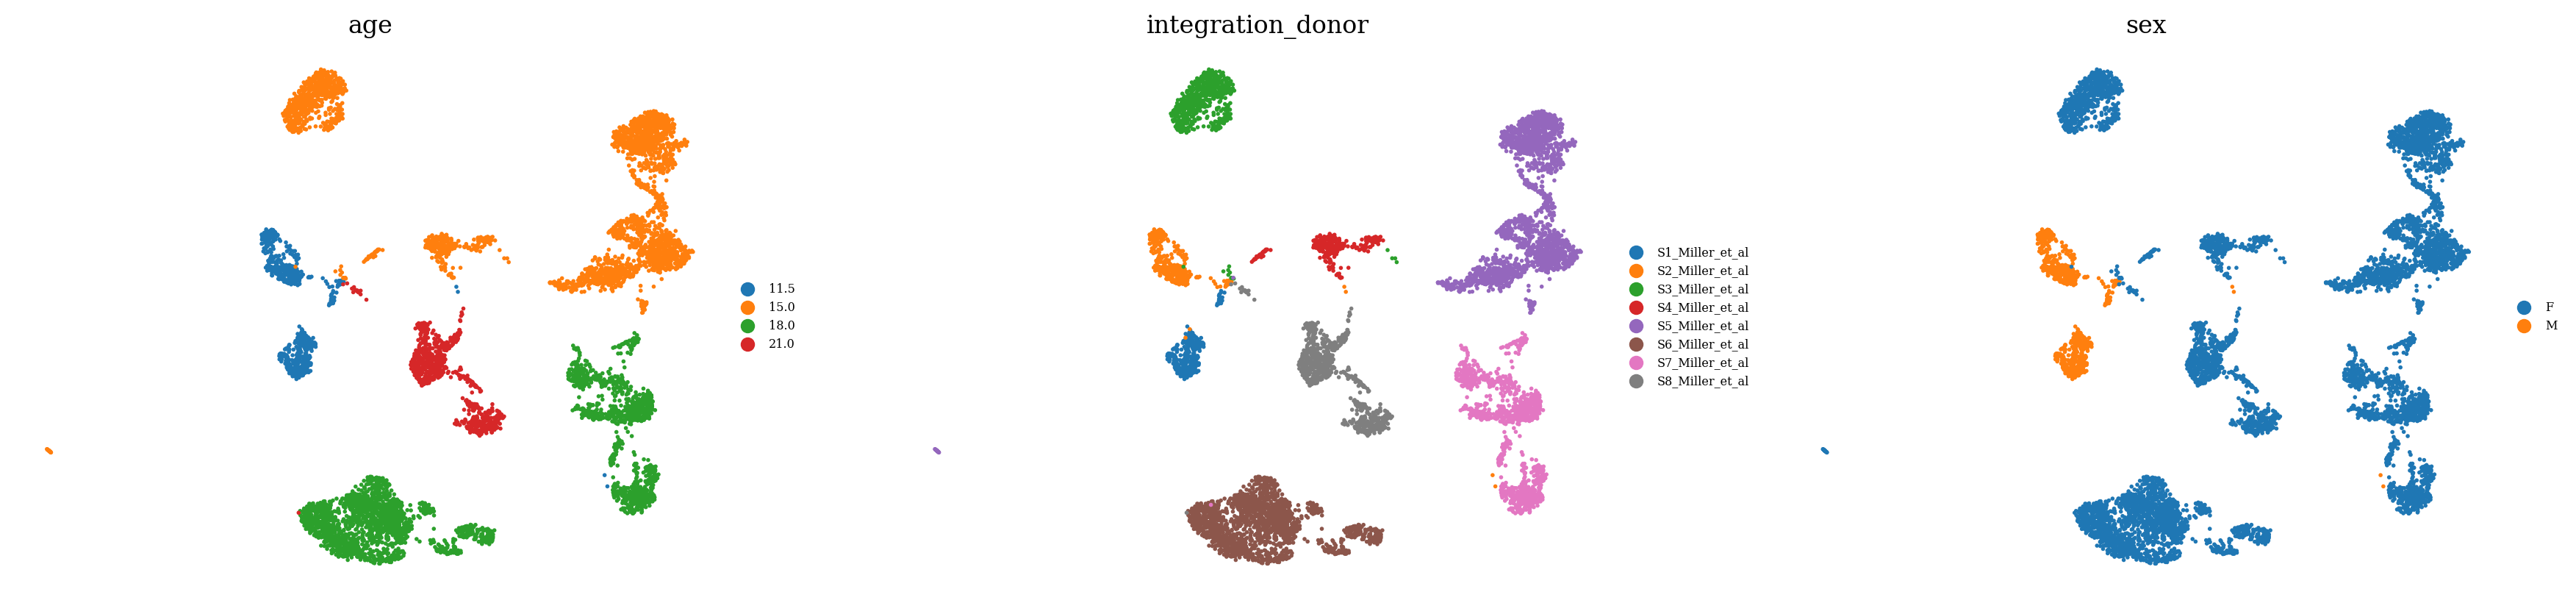

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

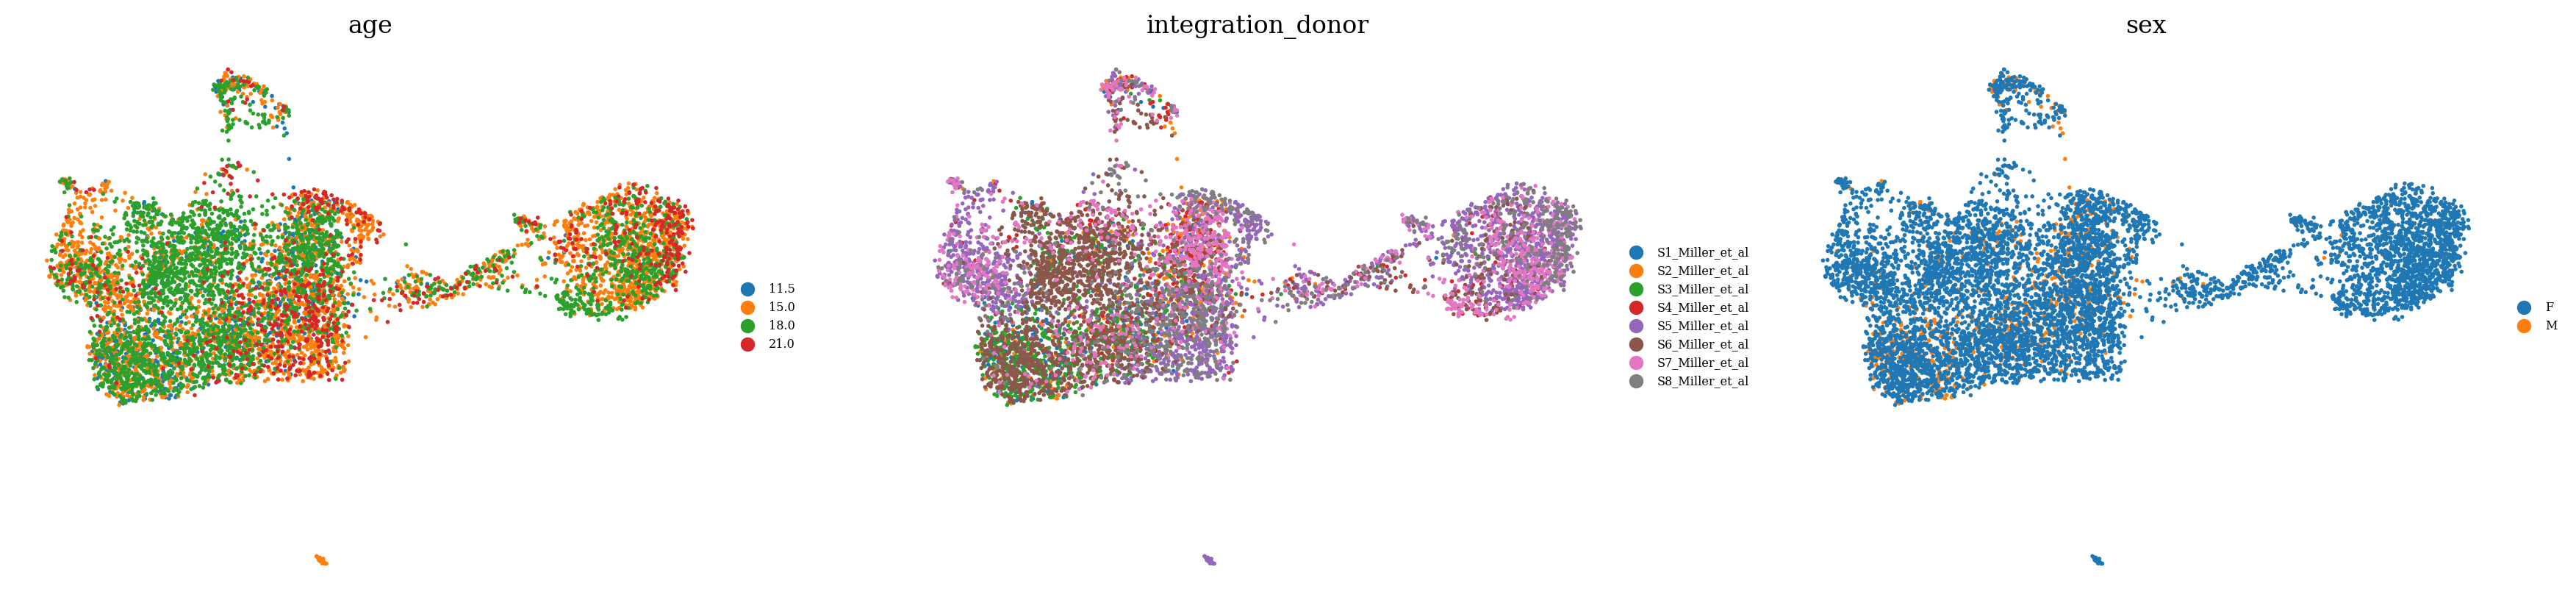

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

 10%|█         | 24/232 [00:00<00:00, 236.01it/s]

 21%|██        | 48/232 [00:00<00:00, 214.41it/s]

 30%|███       | 70/232 [00:00<00:00, 175.18it/s]

 38%|███▊      | 89/232 [00:00<00:00, 161.31it/s]

 46%|████▌     | 106/232 [00:00<00:00, 154.49it/s]

 53%|█████▎    | 122/232 [00:00<00:00, 150.48it/s]

 59%|█████▉    | 138/232 [00:00<00:00, 148.02it/s]

 66%|██████▌   | 153/232 [00:00<00:00, 146.32it/s]

 72%|███████▏  | 168/232 [00:01<00:00, 145.19it/s]

 79%|███████▉  | 183/232 [00:01<00:00, 144.09it/s]

 85%|████████▌ | 198/232 [00:01<00:00, 143.46it/s]

 92%|█████████▏| 213/232 [00:01<00:00, 142.91it/s]

 98%|█████████▊| 228/232 [00:01<00:00, 142.04it/s]

100%|██████████| 232/232 [00:01<00:00, 152.79it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.7235067717555147

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)